In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '6'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_conv_3_VGG_DO_BN(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=3, filters=64, strides=1, padding='same', input_shape=input_shape)) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv1D (kernel_size=3, filters=64, strides=1, padding='same')) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))    
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=3, filters=64*(2**int((i+1)/4)), strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))    
        model.add(Conv1D (kernel_size=3, filters=64*(2**int((i+1)/4)), strides=1, padding='same'))
        model.add(BatchNormalization())        
        model.add(Activation('relu'))    
        model.add(MaxPooling1D(pool_size=2, strides=2))

    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 14):
    model = build_1d_cnn_custom_conv_3_VGG_DO_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 64)         256       
_________________________________________________________________
activation (Activation)      (None, 16000, 64)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 16000, 64)         256       
_________________________________________________________________
activation_1 (Activat

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_20 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_20 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_21 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_21 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 16000, 64)         12352     
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_42 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_42 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_43 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_43 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 16000, 64)         12352     
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_72 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_72 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_72 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_73 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_73 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_73 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 16000, 64)         12352     
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_90 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_90 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_90 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_91 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_91 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_91 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_92 (Conv1D)           (None, 16000, 64)         12352     
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_110 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_110 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_110 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_111 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_111 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_111 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_112 (Conv1D)          (None, 16000, 64)         12352     
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_132 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_132 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_132 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_133 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_133 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_133 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_134 (Conv1D)          (None, 16000, 64)         12352     
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_156 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_156 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_156 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_157 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_157 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_157 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_158 (Conv1D)          (None, 16000, 64)         12352     
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 11.1846 - acc: 0.1921
Epoch 00001: val_loss improved from inf to 10.76626, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_DO_BN_1_conv_checkpoint/001-10.7663.hdf5
36805/36805 [==============================] - 80s 2ms/sample - loss: 11.1847 - acc: 0.1921 - val_loss: 10.7663 - val_acc: 0.2082
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 10.5067 - acc: 0.2764
Epoch 00002: val_loss did not improve from 10.76626
36805/36805 [==============================] - 74s 2ms/sample - loss: 10.5074 - acc: 0.2764 - val_loss: 11.6376 - val_acc: 0.1966
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 10.2556 - acc: 0.3148
Epoch 00003: val_loss did not improve from 10.76626
36805/36805 [==============================] - 74s 2ms/sample - loss: 10.2555 - acc: 0.31

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 6.3369 - acc: 0.5959
Epoch 00028: val_loss did not improve from 9.24207
36805/36805 [==============================] - 74s 2ms/sample - loss: 6.3378 - acc: 0.5958 - val_loss: 10.0297 - val_acc: 0.2758
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 6.3130 - acc: 0.6007
Epoch 00029: val_loss did not improve from 9.24207
36805/36805 [==============================] - 74s 2ms/sample - loss: 6.3130 - acc: 0.6007 - val_loss: 9.3766 - val_acc: 0.2944
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 6.3164 - acc: 0.5999
Epoch 00030: val_loss did not improve from 9.24207
36805/36805 [==============================] - 74s 2ms/sample - loss: 6.3159 - acc: 0.6000 - val_loss: 9.9420 - val_acc: 0.2648
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 6.3184 - acc: 0.5985
Epoch 00031: val_loss did not improve from 9.24207
36805/36805 [==========

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.2371 - acc: 0.7933
Epoch 00055: val_loss did not improve from 7.08903
36805/36805 [==============================] - 74s 2ms/sample - loss: 3.2379 - acc: 0.7933 - val_loss: 9.7256 - val_acc: 0.2576
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.2385 - acc: 0.7929
Epoch 00056: val_loss did not improve from 7.08903
36805/36805 [==============================] - 74s 2ms/sample - loss: 3.2381 - acc: 0.7930 - val_loss: 7.9789 - val_acc: 0.3191
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.2295 - acc: 0.7948
Epoch 00057: val_loss did not improve from 7.08903
36805/36805 [==============================] - 74s 2ms/sample - loss: 3.2290 - acc: 0.7948 - val_loss: 7.8220 - val_acc: 0.3187
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.2269 - acc: 0.7943
Epoch 00058: val_loss did not improve from 7.08903
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 0.1669 - acc: 0.9861
Epoch 00083: val_loss did not improve from 4.86885
36805/36805 [==============================] - 74s 2ms/sample - loss: 0.1669 - acc: 0.9861 - val_loss: 6.7071 - val_acc: 0.3005
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1680 - acc: 0.9859
Epoch 00084: val_loss did not improve from 4.86885
36805/36805 [==============================] - 74s 2ms/sample - loss: 0.1679 - acc: 0.9859 - val_loss: 5.6630 - val_acc: 0.3578
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1602 - acc: 0.9880
Epoch 00085: val_loss did not improve from 4.86885
36805/36805 [==============================] - 74s 2ms/sample - loss: 0.1606 - acc: 0.9880 - val_loss: 5.6068 - val_acc: 0.3823
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1640 - acc: 0.9870
Epoch 00086: val_loss did not improve from 4.86885
36805/36805 [========================

Epoch 113/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1509 - acc: 0.9889
Epoch 00113: val_loss did not improve from 4.86885
36805/36805 [==============================] - 74s 2ms/sample - loss: 0.1509 - acc: 0.9889 - val_loss: 7.6497 - val_acc: 0.2809
Epoch 114/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1477 - acc: 0.9902
Epoch 00114: val_loss did not improve from 4.86885
36805/36805 [==============================] - 74s 2ms/sample - loss: 0.1477 - acc: 0.9902 - val_loss: 5.5733 - val_acc: 0.3867
Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1476 - acc: 0.9898
Epoch 00115: val_loss did not improve from 4.86885
36805/36805 [==============================] - 74s 2ms/sample - loss: 0.1476 - acc: 0.9898 - val_loss: 5.8160 - val_acc: 0.3832
Epoch 116/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1486 - acc: 0.9896
Epoch 00116: val_loss did not improve from 4.86885
36805/36805 [=======

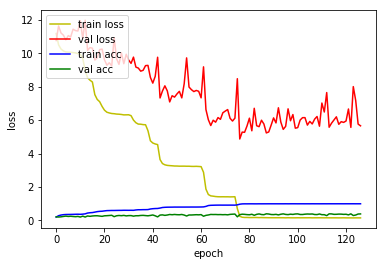

4815/4815 [==============================] - 4s 785us/sample - loss: 5.1888 - acc: 0.3217
Loss: 5.188760419253372 Accuracy: 0.32170302

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 7.1840 - acc: 0.2606
Epoch 00001: val_loss improved from inf to 7.05183, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_DO_BN_2_conv_checkpoint/001-7.0518.hdf5
36805/36805 [==============================] - 142s 4ms/sample - loss: 7.1844 - acc: 0.2606 - val_loss: 7.0518 - val_acc: 0.2257
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 6.8991 - acc: 0.3936
Epoch 00002: val_loss did not improve from 7.05183
36805/36805 [==============================] - 135s 4ms/sample - loss: 6.8996 - acc: 0.3935 - val_loss: 7.4197 - val_acc: 0.2919
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 6.1446 - acc: 0.4745
Epoch 00003: val_loss did not improve from 7.05183
36805/3680

36800/36805 [============================>.] - ETA: 0s - loss: 4.3228 - acc: 0.7171
Epoch 00029: val_loss did not improve from 6.77828
36805/36805 [==============================] - 135s 4ms/sample - loss: 4.3235 - acc: 0.7170 - val_loss: 7.2681 - val_acc: 0.3627
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 4.3267 - acc: 0.7168
Epoch 00030: val_loss did not improve from 6.77828
36805/36805 [==============================] - 135s 4ms/sample - loss: 4.3261 - acc: 0.7169 - val_loss: 7.9372 - val_acc: 0.3408
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 4.3112 - acc: 0.7210
Epoch 00031: val_loss did not improve from 6.77828
36805/36805 [==============================] - 135s 4ms/sample - loss: 4.3115 - acc: 0.7209 - val_loss: 7.1901 - val_acc: 0.3748
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 4.3124 - acc: 0.7203
Epoch 00032: val_loss did not improve from 6.77828
36805/36805 [=====================

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5492 - acc: 0.8826
Epoch 00057: val_loss improved from 5.50143 to 4.78216, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_DO_BN_2_conv_checkpoint/057-4.7822.hdf5
36805/36805 [==============================] - 135s 4ms/sample - loss: 1.5490 - acc: 0.8826 - val_loss: 4.7822 - val_acc: 0.4074
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2904 - acc: 0.9298
Epoch 00058: val_loss did not improve from 4.78216
36805/36805 [==============================] - 134s 4ms/sample - loss: 0.2904 - acc: 0.9298 - val_loss: 5.2001 - val_acc: 0.3552
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1061 - acc: 0.9748
Epoch 00059: val_loss improved from 4.78216 to 3.71484, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_DO_BN_2_conv_checkpoint/059-3.7148.hdf5
36805/36805 [==============================] - 135s 4ms/sample - loss: 0.1061 

Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0345 - acc: 0.9952
Epoch 00086: val_loss did not improve from 3.71484
36805/36805 [==============================] - 134s 4ms/sample - loss: 0.0345 - acc: 0.9952 - val_loss: 4.2374 - val_acc: 0.4645
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0336 - acc: 0.9951
Epoch 00087: val_loss did not improve from 3.71484
36805/36805 [==============================] - 134s 4ms/sample - loss: 0.0336 - acc: 0.9951 - val_loss: 4.5267 - val_acc: 0.4561
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0349 - acc: 0.9951
Epoch 00088: val_loss did not improve from 3.71484
36805/36805 [==============================] - 134s 4ms/sample - loss: 0.0350 - acc: 0.9950 - val_loss: 4.1529 - val_acc: 0.4780
Epoch 89/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0391 - acc: 0.9940
Epoch 00089: val_loss did not improve from 3.71484
36805/36805 [========

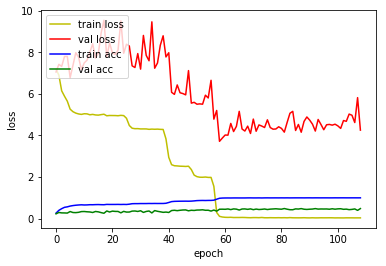

4815/4815 [==============================] - 6s 1ms/sample - loss: 4.0156 - acc: 0.4160
Loss: 4.01559693424625 Accuracy: 0.4159917

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5470 - acc: 0.3350
Epoch 00001: val_loss improved from inf to 2.45329, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_DO_BN_3_conv_checkpoint/001-2.4533.hdf5
36805/36805 [==============================] - 174s 5ms/sample - loss: 2.5469 - acc: 0.3350 - val_loss: 2.4533 - val_acc: 0.3331
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5037 - acc: 0.5529
Epoch 00002: val_loss improved from 2.45329 to 2.04470, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_DO_BN_3_conv_checkpoint/002-2.0447.hdf5
36805/36805 [==============================] - 165s 4ms/sample - loss: 1.5038 - acc: 0.5529 - val_loss: 2.0447 - val_acc: 0.4584
Epoch 3/500
36800/36805 [==========================

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0841 - acc: 0.9773
Epoch 00029: val_loss did not improve from 1.78536
36805/36805 [==============================] - 165s 4ms/sample - loss: 0.0841 - acc: 0.9773 - val_loss: 3.0317 - val_acc: 0.5616
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0689 - acc: 0.9814
Epoch 00030: val_loss did not improve from 1.78536
36805/36805 [==============================] - 165s 4ms/sample - loss: 0.0689 - acc: 0.9814 - val_loss: 2.9939 - val_acc: 0.5698
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0754 - acc: 0.9799
Epoch 00031: val_loss did not improve from 1.78536
36805/36805 [==============================] - 165s 4ms/sample - loss: 0.0754 - acc: 0.9799 - val_loss: 3.3813 - val_acc: 0.5355
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0701 - acc: 0.9814
Epoch 00032: val_loss did not improve from 1.78536
36805/36805 [========

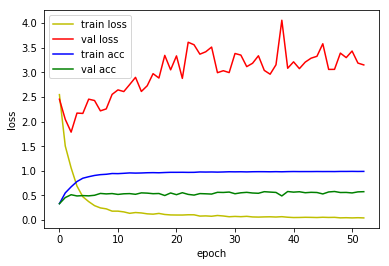

4815/4815 [==============================] - 8s 2ms/sample - loss: 1.8901 - acc: 0.4876
Loss: 1.8901062693551323 Accuracy: 0.4876428

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2435 - acc: 0.3654
Epoch 00001: val_loss improved from inf to 1.93407, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_DO_BN_4_conv_checkpoint/001-1.9341.hdf5
36805/36805 [==============================] - 193s 5ms/sample - loss: 2.2434 - acc: 0.3654 - val_loss: 1.9341 - val_acc: 0.3920
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4593 - acc: 0.5630
Epoch 00002: val_loss improved from 1.93407 to 1.73732, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_DO_BN_4_conv_checkpoint/002-1.7373.hdf5
36805/36805 [==============================] - 179s 5ms/sample - loss: 1.4593 - acc: 0.5630 - val_loss: 1.7373 - val_acc: 0.4987
Epoch 3/500
36800/36805 [========================

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0949 - acc: 0.9730
Epoch 00029: val_loss did not improve from 1.27273
36805/36805 [==============================] - 179s 5ms/sample - loss: 0.0949 - acc: 0.9730 - val_loss: 1.8917 - val_acc: 0.6874
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0860 - acc: 0.9761
Epoch 00030: val_loss did not improve from 1.27273
36805/36805 [==============================] - 179s 5ms/sample - loss: 0.0861 - acc: 0.9760 - val_loss: 1.8995 - val_acc: 0.6781
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1059 - acc: 0.9703
Epoch 00031: val_loss did not improve from 1.27273
36805/36805 [==============================] - 179s 5ms/sample - loss: 0.1061 - acc: 0.9702 - val_loss: 2.1124 - val_acc: 0.6734
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0968 - acc: 0.9735
Epoch 00032: val_loss did not improve from 1.27273
36805/36805 [========

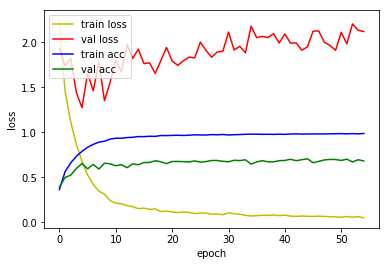

4815/4815 [==============================] - 8s 2ms/sample - loss: 1.4117 - acc: 0.6154
Loss: 1.4116695821470933 Accuracy: 0.61536866

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2321 - acc: 0.3649
Epoch 00001: val_loss improved from inf to 1.74084, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_DO_BN_5_conv_checkpoint/001-1.7408.hdf5
36805/36805 [==============================] - 216s 6ms/sample - loss: 2.2321 - acc: 0.3649 - val_loss: 1.7408 - val_acc: 0.4396
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3856 - acc: 0.5782
Epoch 00002: val_loss improved from 1.74084 to 1.24133, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_DO_BN_5_conv_checkpoint/002-1.2413.hdf5
36805/36805 [==============================] - 196s 5ms/sample - loss: 1.3856 - acc: 0.5782 - val_loss: 1.2413 - val_acc: 0.6198
Epoch 3/500
36800/36805 [=======================

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0866 - acc: 0.9747
Epoch 00029: val_loss did not improve from 1.12194
36805/36805 [==============================] - 196s 5ms/sample - loss: 0.0865 - acc: 0.9747 - val_loss: 1.6108 - val_acc: 0.7384
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0973 - acc: 0.9720
Epoch 00030: val_loss did not improve from 1.12194
36805/36805 [==============================] - 196s 5ms/sample - loss: 0.0973 - acc: 0.9720 - val_loss: 1.9222 - val_acc: 0.6979
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0920 - acc: 0.9728
Epoch 00031: val_loss did not improve from 1.12194
36805/36805 [==============================] - 196s 5ms/sample - loss: 0.0920 - acc: 0.9728 - val_loss: 1.8618 - val_acc: 0.7018
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0860 - acc: 0.9760
Epoch 00032: val_loss did not improve from 1.12194
36805/36805 [========

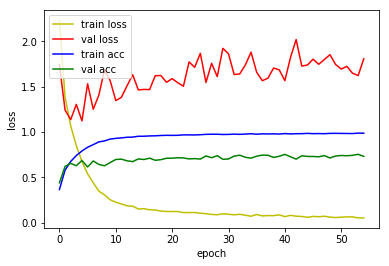

4815/4815 [==============================] - 9s 2ms/sample - loss: 1.2342 - acc: 0.6503
Loss: 1.2341685036880081 Accuracy: 0.6502596

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1150 - acc: 0.3818
Epoch 00001: val_loss improved from inf to 1.77099, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_DO_BN_6_conv_checkpoint/001-1.7710.hdf5
36805/36805 [==============================] - 231s 6ms/sample - loss: 2.1148 - acc: 0.3819 - val_loss: 1.7710 - val_acc: 0.4207
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2656 - acc: 0.6124
Epoch 00002: val_loss improved from 1.77099 to 1.29125, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_DO_BN_6_conv_checkpoint/002-1.2912.hdf5
36805/36805 [==============================] - 205s 6ms/sample - loss: 1.2656 - acc: 0.6124 - val_loss: 1.2912 - val_acc: 0.6245
Epoch 3/500
36800/36805 [========================

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1215 - acc: 0.9631
Epoch 00028: val_loss did not improve from 0.80841
36805/36805 [==============================] - 204s 6ms/sample - loss: 0.1217 - acc: 0.9631 - val_loss: 1.0317 - val_acc: 0.7973
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1289 - acc: 0.9613
Epoch 00029: val_loss did not improve from 0.80841
36805/36805 [==============================] - 204s 6ms/sample - loss: 0.1290 - acc: 0.9613 - val_loss: 1.2146 - val_acc: 0.7759
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1004 - acc: 0.9688
Epoch 00030: val_loss did not improve from 0.80841
36805/36805 [==============================] - 205s 6ms/sample - loss: 0.1004 - acc: 0.9688 - val_loss: 0.9877 - val_acc: 0.8053
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0954 - acc: 0.9713
Epoch 00031: val_loss did not improve from 0.80841
36805/36805 [========

Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0574 - acc: 0.9839
Epoch 00058: val_loss did not improve from 0.80841
36805/36805 [==============================] - 204s 6ms/sample - loss: 0.0574 - acc: 0.9839 - val_loss: 1.0558 - val_acc: 0.8157
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0659 - acc: 0.9810
Epoch 00059: val_loss did not improve from 0.80841
36805/36805 [==============================] - 204s 6ms/sample - loss: 0.0659 - acc: 0.9810 - val_loss: 1.0395 - val_acc: 0.8223
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0631 - acc: 0.9832
Epoch 00060: val_loss did not improve from 0.80841
36805/36805 [==============================] - 204s 6ms/sample - loss: 0.0631 - acc: 0.9832 - val_loss: 1.0063 - val_acc: 0.8269
Epoch 61/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0617 - acc: 0.9832
Epoch 00061: val_loss did not improve from 0.80841
36805/36805 [========

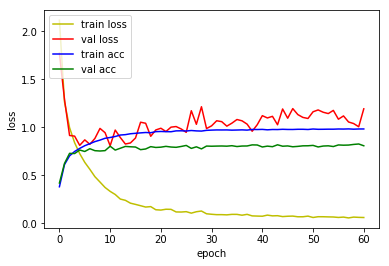

4815/4815 [==============================] - 10s 2ms/sample - loss: 0.9189 - acc: 0.7697
Loss: 0.9188817410825569 Accuracy: 0.7696781

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2099 - acc: 0.3437
Epoch 00001: val_loss improved from inf to 1.82124, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_DO_BN_7_conv_checkpoint/001-1.8212.hdf5
36805/36805 [==============================] - 247s 7ms/sample - loss: 2.2098 - acc: 0.3437 - val_loss: 1.8212 - val_acc: 0.4298
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3053 - acc: 0.5942
Epoch 00002: val_loss improved from 1.82124 to 0.99661, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_DO_BN_7_conv_checkpoint/002-0.9966.hdf5
36805/36805 [==============================] - 210s 6ms/sample - loss: 1.3052 - acc: 0.5942 - val_loss: 0.9966 - val_acc: 0.7116
Epoch 3/500
36800/36805 [=======================

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1283 - acc: 0.9576
Epoch 00027: val_loss did not improve from 0.58457
36805/36805 [==============================] - 209s 6ms/sample - loss: 0.1283 - acc: 0.9576 - val_loss: 0.7019 - val_acc: 0.8418
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1252 - acc: 0.9595
Epoch 00028: val_loss did not improve from 0.58457
36805/36805 [==============================] - 209s 6ms/sample - loss: 0.1252 - acc: 0.9595 - val_loss: 0.7135 - val_acc: 0.8477
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1138 - acc: 0.9648
Epoch 00029: val_loss did not improve from 0.58457
36805/36805 [==============================] - 209s 6ms/sample - loss: 0.1140 - acc: 0.9648 - val_loss: 0.6629 - val_acc: 0.8556
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1217 - acc: 0.9615
Epoch 00030: val_loss did not improve from 0.58457
36805/36805 [========

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0867 - acc: 0.9738
Epoch 00057: val_loss did not improve from 0.58457
36805/36805 [==============================] - 209s 6ms/sample - loss: 0.0867 - acc: 0.9738 - val_loss: 0.8217 - val_acc: 0.8612
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0543 - acc: 0.9829
Epoch 00058: val_loss did not improve from 0.58457
36805/36805 [==============================] - 209s 6ms/sample - loss: 0.0543 - acc: 0.9829 - val_loss: 0.7618 - val_acc: 0.8630
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0519 - acc: 0.9843
Epoch 00059: val_loss did not improve from 0.58457
36805/36805 [==============================] - 209s 6ms/sample - loss: 0.0519 - acc: 0.9843 - val_loss: 0.7129 - val_acc: 0.8707

1D_CNN_custom_conv_3_VGG_pool_2_DO_BN_7_conv Model


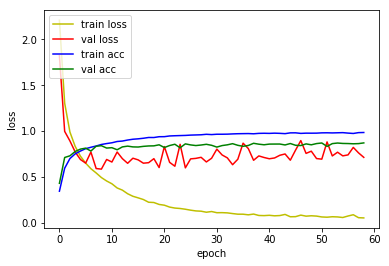

4815/4815 [==============================] - 11s 2ms/sample - loss: 0.6970 - acc: 0.7992
Loss: 0.6969671004657805 Accuracy: 0.79916924

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2898 - acc: 0.3079
Epoch 00001: val_loss improved from inf to 1.64585, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_DO_BN_8_conv_checkpoint/001-1.6459.hdf5
36805/36805 [==============================] - 253s 7ms/sample - loss: 2.2897 - acc: 0.3079 - val_loss: 1.6459 - val_acc: 0.4610
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3210 - acc: 0.5845
Epoch 00002: val_loss improved from 1.64585 to 1.00206, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_DO_BN_8_conv_checkpoint/002-1.0021.hdf5
36805/36805 [==============================] - 203s 6ms/sample - loss: 1.3210 - acc: 0.5845 - val_loss: 1.0021 - val_acc: 0.6951
Epoch 3/500
36800/36805 [======================

36800/36805 [============================>.] - ETA: 0s - loss: 0.1337 - acc: 0.9573
Epoch 00025: val_loss did not improve from 0.42376
36805/36805 [==============================] - 203s 6ms/sample - loss: 0.1340 - acc: 0.9572 - val_loss: 0.4804 - val_acc: 0.8789
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1326 - acc: 0.9570
Epoch 00026: val_loss did not improve from 0.42376
36805/36805 [==============================] - 203s 6ms/sample - loss: 0.1327 - acc: 0.9570 - val_loss: 0.5078 - val_acc: 0.8877
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1404 - acc: 0.9570
Epoch 00027: val_loss did not improve from 0.42376
36805/36805 [==============================] - 203s 6ms/sample - loss: 0.1404 - acc: 0.9570 - val_loss: 0.5297 - val_acc: 0.8828
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1053 - acc: 0.9657
Epoch 00028: val_loss did not improve from 0.42376
36805/36805 [=====================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0761 - acc: 0.9760
Epoch 00054: val_loss did not improve from 0.41323
36805/36805 [==============================] - 202s 5ms/sample - loss: 0.0761 - acc: 0.9760 - val_loss: 0.5243 - val_acc: 0.8996
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0439 - acc: 0.9869
Epoch 00055: val_loss did not improve from 0.41323
36805/36805 [==============================] - 202s 5ms/sample - loss: 0.0439 - acc: 0.9869 - val_loss: 0.4849 - val_acc: 0.9089
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0429 - acc: 0.9868
Epoch 00056: val_loss did not improve from 0.41323
36805/36805 [==============================] - 202s 5ms/sample - loss: 0.0429 - acc: 0.9868 - val_loss: 0.4854 - val_acc: 0.9064
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0406 - acc: 0.9875
Epoch 00057: val_loss did not improve from 0.41323
36805/36805 [=====================

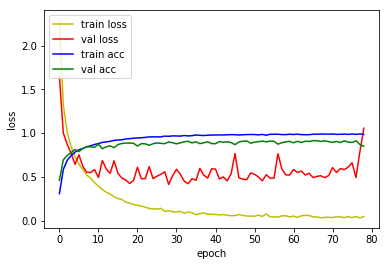

4815/4815 [==============================] - 10s 2ms/sample - loss: 0.4885 - acc: 0.8773
Loss: 0.48854290922854177 Accuracy: 0.87725854

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2058 - acc: 0.3310
Epoch 00001: val_loss improved from inf to 1.74293, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_DO_BN_9_conv_checkpoint/001-1.7429.hdf5
36805/36805 [==============================] - 270s 7ms/sample - loss: 2.2057 - acc: 0.3310 - val_loss: 1.7429 - val_acc: 0.4421
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2359 - acc: 0.6133
Epoch 00002: val_loss improved from 1.74293 to 1.10657, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_DO_BN_9_conv_checkpoint/002-1.1066.hdf5
36805/36805 [==============================] - 206s 6ms/sample - loss: 1.2358 - acc: 0.6133 - val_loss: 1.1066 - val_acc: 0.6804
Epoch 3/500
36800/36805 [=====================

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0942 - acc: 0.9688
Epoch 00026: val_loss did not improve from 0.30548
36805/36805 [==============================] - 206s 6ms/sample - loss: 0.0942 - acc: 0.9687 - val_loss: 0.3121 - val_acc: 0.9355
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0866 - acc: 0.9723
Epoch 00027: val_loss did not improve from 0.30548
36805/36805 [==============================] - 206s 6ms/sample - loss: 0.0866 - acc: 0.9723 - val_loss: 0.3328 - val_acc: 0.9257
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0709 - acc: 0.9771
Epoch 00028: val_loss did not improve from 0.30548
36805/36805 [==============================] - 206s 6ms/sample - loss: 0.0711 - acc: 0.9771 - val_loss: 0.3482 - val_acc: 0.9283
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0775 - acc: 0.9750
Epoch 00029: val_loss did not improve from 0.30548
36805/36805 [========

36805/36805 [==============================] - 206s 6ms/sample - loss: 0.0263 - acc: 0.9917 - val_loss: 0.2904 - val_acc: 0.9453
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0321 - acc: 0.9891
Epoch 00056: val_loss did not improve from 0.29041
36805/36805 [==============================] - 206s 6ms/sample - loss: 0.0321 - acc: 0.9891 - val_loss: 0.3935 - val_acc: 0.9227
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0351 - acc: 0.9881
Epoch 00057: val_loss did not improve from 0.29041
36805/36805 [==============================] - 206s 6ms/sample - loss: 0.0351 - acc: 0.9881 - val_loss: 0.3360 - val_acc: 0.9345
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0294 - acc: 0.9908
Epoch 00058: val_loss did not improve from 0.29041
36805/36805 [==============================] - 206s 6ms/sample - loss: 0.0294 - acc: 0.9908 - val_loss: 0.4346 - val_acc: 0.9241
Epoch 59/500
36800/36805 [==============

36800/36805 [============================>.] - ETA: 0s - loss: 0.0202 - acc: 0.9937
Epoch 00085: val_loss did not improve from 0.29041
36805/36805 [==============================] - 206s 6ms/sample - loss: 0.0202 - acc: 0.9938 - val_loss: 0.3785 - val_acc: 0.9383
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0199 - acc: 0.9937
Epoch 00086: val_loss did not improve from 0.29041
36805/36805 [==============================] - 206s 6ms/sample - loss: 0.0203 - acc: 0.9936 - val_loss: 0.4638 - val_acc: 0.9213
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0358 - acc: 0.9892
Epoch 00087: val_loss did not improve from 0.29041
36805/36805 [==============================] - 206s 6ms/sample - loss: 0.0358 - acc: 0.9892 - val_loss: 0.4242 - val_acc: 0.9269
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0181 - acc: 0.9946
Epoch 00088: val_loss did not improve from 0.29041
36805/36805 [=====================

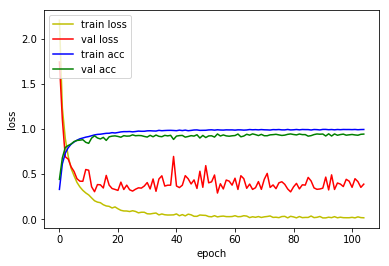

4815/4815 [==============================] - 11s 2ms/sample - loss: 0.3295 - acc: 0.9298
Loss: 0.3295109964985505 Accuracy: 0.9298027

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2188 - acc: 0.3239
Epoch 00001: val_loss improved from inf to 1.79542, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_DO_BN_10_conv_checkpoint/001-1.7954.hdf5
36805/36805 [==============================] - 285s 8ms/sample - loss: 2.2186 - acc: 0.3240 - val_loss: 1.7954 - val_acc: 0.4072
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2323 - acc: 0.6139
Epoch 00002: val_loss improved from 1.79542 to 0.83331, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_DO_BN_10_conv_checkpoint/002-0.8333.hdf5
36805/36805 [==============================] - 209s 6ms/sample - loss: 1.2322 - acc: 0.6140 - val_loss: 0.8333 - val_acc: 0.7664
Epoch 3/500
36800/36805 [=====================

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0564 - acc: 0.9813
Epoch 00026: val_loss did not improve from 0.19048
36805/36805 [==============================] - 209s 6ms/sample - loss: 0.0565 - acc: 0.9813 - val_loss: 0.2861 - val_acc: 0.9341
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0711 - acc: 0.9765
Epoch 00027: val_loss did not improve from 0.19048
36805/36805 [==============================] - 209s 6ms/sample - loss: 0.0711 - acc: 0.9765 - val_loss: 0.3084 - val_acc: 0.9245
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0541 - acc: 0.9822
Epoch 00028: val_loss did not improve from 0.19048
36805/36805 [==============================] - 209s 6ms/sample - loss: 0.0541 - acc: 0.9822 - val_loss: 0.2421 - val_acc: 0.9453
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0558 - acc: 0.9819
Epoch 00029: val_loss did not improve from 0.19048
36805/36805 [========

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0207 - acc: 0.9935
Epoch 00056: val_loss did not improve from 0.19048
36805/36805 [==============================] - 208s 6ms/sample - loss: 0.0207 - acc: 0.9935 - val_loss: 0.2054 - val_acc: 0.9585
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0202 - acc: 0.9932
Epoch 00057: val_loss did not improve from 0.19048
36805/36805 [==============================] - 209s 6ms/sample - loss: 0.0202 - acc: 0.9932 - val_loss: 0.2141 - val_acc: 0.9527
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0274 - acc: 0.9911
Epoch 00058: val_loss did not improve from 0.19048
36805/36805 [==============================] - 209s 6ms/sample - loss: 0.0274 - acc: 0.9911 - val_loss: 0.2190 - val_acc: 0.9499
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0236 - acc: 0.9923
Epoch 00059: val_loss did not improve from 0.19048
36805/36805 [========

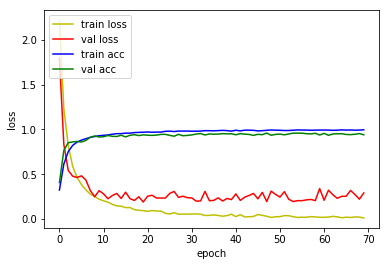

4815/4815 [==============================] - 11s 2ms/sample - loss: 0.2393 - acc: 0.9321
Loss: 0.23932929773073205 Accuracy: 0.93208724

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3701 - acc: 0.2876
Epoch 00001: val_loss improved from inf to 1.57649, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_DO_BN_11_conv_checkpoint/001-1.5765.hdf5
36805/36805 [==============================] - 313s 9ms/sample - loss: 2.3699 - acc: 0.2876 - val_loss: 1.5765 - val_acc: 0.4805
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1926 - acc: 0.6228
Epoch 00002: val_loss improved from 1.57649 to 0.74567, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_DO_BN_11_conv_checkpoint/002-0.7457.hdf5
36805/36805 [==============================] - 211s 6ms/sample - loss: 1.1925 - acc: 0.6228 - val_loss: 0.7457 - val_acc: 0.7803
Epoch 3/500
36800/36805 [===================

36805/36805 [==============================] - 211s 6ms/sample - loss: 0.0665 - acc: 0.9780 - val_loss: 0.1246 - val_acc: 0.9644
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0442 - acc: 0.9866
Epoch 00026: val_loss did not improve from 0.12459
36805/36805 [==============================] - 211s 6ms/sample - loss: 0.0442 - acc: 0.9866 - val_loss: 0.1569 - val_acc: 0.9576
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0512 - acc: 0.9837
Epoch 00027: val_loss did not improve from 0.12459
36805/36805 [==============================] - 211s 6ms/sample - loss: 0.0512 - acc: 0.9838 - val_loss: 0.1880 - val_acc: 0.9518
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0480 - acc: 0.9847
Epoch 00028: val_loss did not improve from 0.12459
36805/36805 [==============================] - 211s 6ms/sample - loss: 0.0480 - acc: 0.9847 - val_loss: 0.1719 - val_acc: 0.9555
Epoch 29/500
36800/36805 [==============

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0266 - acc: 0.9915
Epoch 00055: val_loss did not improve from 0.12355
36805/36805 [==============================] - 211s 6ms/sample - loss: 0.0267 - acc: 0.9914 - val_loss: 0.1778 - val_acc: 0.9648
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0256 - acc: 0.9920
Epoch 00056: val_loss did not improve from 0.12355
36805/36805 [==============================] - 211s 6ms/sample - loss: 0.0256 - acc: 0.9920 - val_loss: 0.1495 - val_acc: 0.9655
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0145 - acc: 0.9960
Epoch 00057: val_loss did not improve from 0.12355
36805/36805 [==============================] - 211s 6ms/sample - loss: 0.0145 - acc: 0.9960 - val_loss: 0.1529 - val_acc: 0.9667
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0146 - acc: 0.9958
Epoch 00058: val_loss did not improve from 0.12355
36805/36805 [========

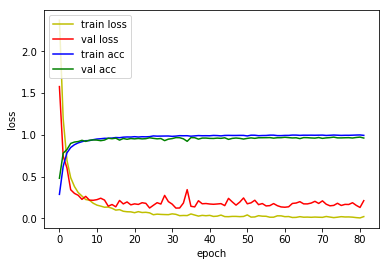

4815/4815 [==============================] - 11s 2ms/sample - loss: 0.1635 - acc: 0.9545
Loss: 0.16346425907783063 Accuracy: 0.9545171

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3987 - acc: 0.2868
Epoch 00001: val_loss improved from inf to 1.76349, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_DO_BN_12_conv_checkpoint/001-1.7635.hdf5
36805/36805 [==============================] - 336s 9ms/sample - loss: 2.3989 - acc: 0.2868 - val_loss: 1.7635 - val_acc: 0.4419
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0961 - acc: 0.6549
Epoch 00002: val_loss improved from 1.76349 to 0.66680, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_DO_BN_12_conv_checkpoint/002-0.6668.hdf5
36805/36805 [==============================] - 213s 6ms/sample - loss: 1.0963 - acc: 0.6548 - val_loss: 0.6668 - val_acc: 0.7932
Epoch 3/500
36800/36805 [====================

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0531 - acc: 0.9829
Epoch 00026: val_loss did not improve from 0.12038
36805/36805 [==============================] - 213s 6ms/sample - loss: 0.0531 - acc: 0.9829 - val_loss: 0.1597 - val_acc: 0.9560
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0418 - acc: 0.9870
Epoch 00027: val_loss did not improve from 0.12038
36805/36805 [==============================] - 213s 6ms/sample - loss: 0.0418 - acc: 0.9870 - val_loss: 0.1442 - val_acc: 0.9590
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0436 - acc: 0.9860
Epoch 00028: val_loss improved from 0.12038 to 0.11801, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_DO_BN_12_conv_checkpoint/028-0.1180.hdf5
36805/36805 [==============================] - 213s 6ms/sample - loss: 0.0436 - acc: 0.9860 - val_loss: 0.1180 - val_acc: 0.9674
Epoch 29/500
36800/36805 [============================>.] 

36800/36805 [============================>.] - ETA: 0s - loss: 0.0297 - acc: 0.9909
Epoch 00055: val_loss did not improve from 0.11801
36805/36805 [==============================] - 213s 6ms/sample - loss: 0.0297 - acc: 0.9909 - val_loss: 0.1636 - val_acc: 0.9639
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0170 - acc: 0.9946
Epoch 00056: val_loss did not improve from 0.11801
36805/36805 [==============================] - 213s 6ms/sample - loss: 0.0170 - acc: 0.9946 - val_loss: 0.1263 - val_acc: 0.9693
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0154 - acc: 0.9950
Epoch 00057: val_loss did not improve from 0.11801
36805/36805 [==============================] - 213s 6ms/sample - loss: 0.0154 - acc: 0.9950 - val_loss: 0.1632 - val_acc: 0.9604
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0155 - acc: 0.9949
Epoch 00058: val_loss did not improve from 0.11801
36805/36805 [=====================

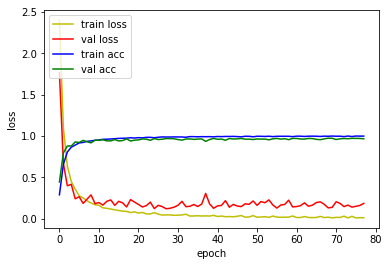

4815/4815 [==============================] - 12s 3ms/sample - loss: 0.1843 - acc: 0.9516
Loss: 0.1843351250156559 Accuracy: 0.95160955

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0713 - acc: 0.3908
Epoch 00001: val_loss improved from inf to 1.44285, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_DO_BN_13_conv_checkpoint/001-1.4429.hdf5
36805/36805 [==============================] - 365s 10ms/sample - loss: 2.0713 - acc: 0.3909 - val_loss: 1.4429 - val_acc: 0.5318
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8217 - acc: 0.7424
Epoch 00002: val_loss improved from 1.44285 to 0.53528, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_DO_BN_13_conv_checkpoint/002-0.5353.hdf5
36805/36805 [==============================] - 216s 6ms/sample - loss: 0.8218 - acc: 0.7424 - val_loss: 0.5353 - val_acc: 0.8281
Epoch 3/500
36800/36805 [===================

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0360 - acc: 0.9886
Epoch 00026: val_loss did not improve from 0.13891
36805/36805 [==============================] - 217s 6ms/sample - loss: 0.0360 - acc: 0.9886 - val_loss: 0.1930 - val_acc: 0.9504
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0442 - acc: 0.9854
Epoch 00027: val_loss did not improve from 0.13891
36805/36805 [==============================] - 217s 6ms/sample - loss: 0.0442 - acc: 0.9854 - val_loss: 0.2087 - val_acc: 0.9532
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0420 - acc: 0.9867
Epoch 00028: val_loss did not improve from 0.13891
36805/36805 [==============================] - 217s 6ms/sample - loss: 0.0420 - acc: 0.9867 - val_loss: 0.1892 - val_acc: 0.9504
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0445 - acc: 0.9851
Epoch 00029: val_loss did not improve from 0.13891
36805/36805 [========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0181 - acc: 0.9941
Epoch 00055: val_loss did not improve from 0.13304
36805/36805 [==============================] - 218s 6ms/sample - loss: 0.0181 - acc: 0.9941 - val_loss: 0.1758 - val_acc: 0.9632
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0183 - acc: 0.9940
Epoch 00056: val_loss did not improve from 0.13304
36805/36805 [==============================] - 217s 6ms/sample - loss: 0.0183 - acc: 0.9939 - val_loss: 0.2840 - val_acc: 0.9518
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0257 - acc: 0.9920
Epoch 00057: val_loss did not improve from 0.13304
36805/36805 [==============================] - 217s 6ms/sample - loss: 0.0257 - acc: 0.9920 - val_loss: 0.1592 - val_acc: 0.9646
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0125 - acc: 0.9965
Epoch 00058: val_loss did not improve from 0.13304
36805/36805 [=====================

Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0090 - acc: 0.9970
Epoch 00085: val_loss did not improve from 0.13304
36805/36805 [==============================] - 217s 6ms/sample - loss: 0.0090 - acc: 0.9970 - val_loss: 0.1908 - val_acc: 0.9655
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0146 - acc: 0.9951
Epoch 00086: val_loss did not improve from 0.13304
36805/36805 [==============================] - 217s 6ms/sample - loss: 0.0146 - acc: 0.9951 - val_loss: 0.1849 - val_acc: 0.9648
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0077 - acc: 0.9977
Epoch 00087: val_loss did not improve from 0.13304
36805/36805 [==============================] - 217s 6ms/sample - loss: 0.0077 - acc: 0.9977 - val_loss: 0.1855 - val_acc: 0.9644
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0121 - acc: 0.9963
Epoch 00088: val_loss did not improve from 0.13304
36805/36805 [========

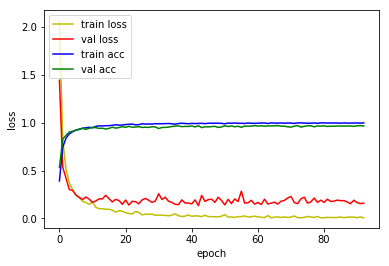

4815/4815 [==============================] - 13s 3ms/sample - loss: 0.1681 - acc: 0.9562
Loss: 0.16810978780329414 Accuracy: 0.9561786



In [10]:
base = '1D_CNN_custom_conv_3_VGG_pool_2_DO_BN'

for i in range(1, 14):
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_conv_3_VGG_DO_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [8]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_conv_3_VGG_pool_2_DO_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 14):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_pool_2_DO_BN_3_conv Model
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_188 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_188 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_188 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_189 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_189 ( (None, 16000, 64)       

4815/4815 [==============================] - 8s 2ms/sample - loss: 1.4117 - acc: 0.6154
Loss: 1.4116695821470933 Accuracy: 0.61536866

1D_CNN_custom_conv_3_VGG_pool_2_DO_BN_5_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_202 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_202 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_202 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_203 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_203 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_203 (Activa

4815/4815 [==============================] - 9s 2ms/sample - loss: 0.9189 - acc: 0.7697
Loss: 0.9188817410825569 Accuracy: 0.7696781

1D_CNN_custom_conv_3_VGG_pool_2_DO_BN_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_224 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_224 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_224 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_225 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_225 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_225 (Activat

4815/4815 [==============================] - 10s 2ms/sample - loss: 0.4885 - acc: 0.8773
Loss: 0.48854290922854177 Accuracy: 0.87725854

1D_CNN_custom_conv_3_VGG_pool_2_DO_BN_9_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_254 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_254 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_254 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_255 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_255 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_255 (Acti

4815/4815 [==============================] - 10s 2ms/sample - loss: 0.3295 - acc: 0.9298
Loss: 0.3295109964985505 Accuracy: 0.9298027

1D_CNN_custom_conv_3_VGG_pool_2_DO_BN_10_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_272 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_272 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_272 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_273 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_273 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_273 (Activ

4815/4815 [==============================] - 11s 2ms/sample - loss: 0.2393 - acc: 0.9321
Loss: 0.23932929773073205 Accuracy: 0.93208724

1D_CNN_custom_conv_3_VGG_pool_2_DO_BN_11_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_292 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_292 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_292 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_293 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_293 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_293 (Act

4815/4815 [==============================] - 11s 2ms/sample - loss: 0.1635 - acc: 0.9545
Loss: 0.16346425907783063 Accuracy: 0.9545171

1D_CNN_custom_conv_3_VGG_pool_2_DO_BN_12_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_314 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_314 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_314 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_315 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_315 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_315 (Acti

4815/4815 [==============================] - 11s 2ms/sample - loss: 0.1843 - acc: 0.9516
Loss: 0.1843351250156559 Accuracy: 0.95160955

1D_CNN_custom_conv_3_VGG_pool_2_DO_BN_13_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_338 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_338 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_338 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_339 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_339 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_339 (Acti

4815/4815 [==============================] - 11s 2ms/sample - loss: 0.1681 - acc: 0.9562
Loss: 0.16810978780329414 Accuracy: 0.9561786


In [9]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
# base = '1D_CNN_custom_DO_BN'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(3, 14):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_pool_2_DO_BN_3_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_188 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_188 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_188 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_189 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_189 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_189 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_190 (Conv1D)     

4815/4815 [==============================] - 10s 2ms/sample - loss: 2.0770 - acc: 0.6881
Loss: 2.0769994277696617 Accuracy: 0.68805814

1D_CNN_custom_conv_3_VGG_pool_2_DO_BN_6_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_212 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_212 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_212 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_213 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_213 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_213 (Activ

4815/4815 [==============================] - 11s 2ms/sample - loss: 0.8560 - acc: 0.8444
Loss: 0.8560446065162944 Accuracy: 0.84444445

1D_CNN_custom_conv_3_VGG_pool_2_DO_BN_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_238 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_238 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_238 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_239 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_239 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_239 (Activ

4815/4815 [==============================] - 12s 2ms/sample - loss: 1.1732 - acc: 0.8181
Loss: 1.1731528491864942 Accuracy: 0.81806856

1D_CNN_custom_conv_3_VGG_pool_2_DO_BN_9_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_254 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_254 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_254 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_255 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_255 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_255 (Activ

4815/4815 [==============================] - 12s 2ms/sample - loss: 0.4205 - acc: 0.9225
Loss: 0.4205197477591372 Accuracy: 0.92253375

1D_CNN_custom_conv_3_VGG_pool_2_DO_BN_10_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_272 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_272 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_272 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_273 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_273 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_273 (Acti

4815/4815 [==============================] - 12s 3ms/sample - loss: 0.3732 - acc: 0.9298
Loss: 0.373246261121769 Accuracy: 0.9298027

1D_CNN_custom_conv_3_VGG_pool_2_DO_BN_11_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_292 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_292 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_292 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_293 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_293 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_293 (Activa

4815/4815 [==============================] - 12s 3ms/sample - loss: 0.2265 - acc: 0.9529
Loss: 0.22646390257309884 Accuracy: 0.95285565

1D_CNN_custom_conv_3_VGG_pool_2_DO_BN_12_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_314 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_314 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_314 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_315 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_315 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_315 (Act

4815/4815 [==============================] - 13s 3ms/sample - loss: 0.2041 - acc: 0.9560
Loss: 0.20412863804431688 Accuracy: 0.95597094

1D_CNN_custom_conv_3_VGG_pool_2_DO_BN_13_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_338 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_338 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_338 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_339 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_339 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_339 (Act

4815/4815 [==============================] - 13s 3ms/sample - loss: 0.1841 - acc: 0.9622
Loss: 0.18411765205093006 Accuracy: 0.9622015
